# ATMS 523 Final Project
## Wenhan Tang (UIN: 678054985)

This project uses ERA5 reanalysis data and machine-learning methods to predict daily precipitation over the U.S. Midwest. Surface meteorological variables (wind, temperature, humidity, pressure, and cloud properties) are extracted for each grid cell and used as predictors, while precipitation occurrence is defined from daily accumulated rainfall.

To account for seasonal differences, separate Random Forest models are trained for winter, spring, summer, and autumn. Model performance is evaluated using accuracy, precision, and recall, both overall and spatially across the Midwest. Feature importance and SHAP analyses highlight the key drivers of precipitation occurrence.

A one-day case study further compares predicted and true precipitation maps, illustrating the model’s ability to capture regional precipitation patterns.

### Import packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

from data_proc import extract_point_data, extract_region_data, extract_oneday_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

### 1. Access ERA5 reanalysis data for midwest in 2024

In [2]:
PRECIP_THRESHOLD = 0.0001 # unit: m

df_midwest = extract_region_data(
    lon1=-105, lon2=-80,
    lat1=35, lat2=49
)

df_midwest["precip_flag"] = (df_midwest["tp"] > PRECIP_THRESHOLD).astype(int)
df_midwest

,lat,lon,date,number,u10,v10,d2m,t2m,msl,tcc,tciw,tclw,tcrw,tp,doy,precip_flag
0,49.0,-105.0,2024-01-01,0,3.670751,0.818972,267.509552,270.498291,101760.789062,0.239684,0.005428,0.001996,0.000000,2.769629e-05,1,0
1,49.0,-105.0,2024-01-02,0,2.782053,-1.163970,266.397949,268.092041,102259.039062,0.458837,0.005441,0.006306,0.000000,0.000000e+00,2,0
2,49.0,-105.0,2024-01-03,0,-1.022160,0.089275,262.899261,265.457764,102735.039062,0.888680,0.007662,0.025965,0.000000,2.582868e-07,3,0
3,49.0,-105.0,2024-01-04,0,-0.023366,2.758645,264.500610,266.312958,102042.281250,0.250773,0.000350,0.002789,0.000000,0.000000e+00,4,0
4,49.0,-105.0,2024-01-05,0,1.030224,0.077323,266.757843,267.985443,101452.812500,0.976543,0.041725,0.081753,0.000000,3.349781e-05,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2107057,35.0,-80.0,2024-12-27,0,-2.004847,-1.436956,276.034912,280.444763,102755.000000,0.974112,0.006709,0.537635,0.012436,7.313490e-05,362,0
2107058,35.0,-80.0,2024-12-28,0,-1.193716,0.609897,283.542084,284.365631,102370.351562,0.995209,0.034618,0.336775,0.018972,1.731912e-04,363,1
2107059,35.0,-80.0,2024-12-29,0,-1.344959,4.272457,288.403015,289.564850,101617.320312,0.903491,0.037827,0.320005,0.024414,3.965100e-04,364,1
2107060,35.0,-80.0,2024-12-30,0,2.020093,1.642588,282.686432,286.595154,101122.367188,0.431834,0.001212,0.072023,0.003337,4.021327e-05,365,0


In [3]:
# Define seasons based on the DOY
seasons = {
    "winter":  list(range(  1,  80)) + list(range(355, 367)),
    "spring":  list(range( 80, 172)),
    "summer":  list(range(172, 266)),
    "autumn":  list(range(266, 355)),
}

# Features
feature_cols = ["lat", "lon", "u10", "v10", "d2m", "t2m", "msl", 
                "tcc", "tciw", "tclw", "tcrw"]

# Target
target_col = "precip_flag"

### 2. Train separate Random Forest models for each season, and present both their predictive performance and feature importances


===== WINTER =====
Train samples: 366720, Test samples: 157167
Train Acc: 0.993
Test Acc:  0.980
Confusion matrix (test set):
[[130754    939]
 [  2137  23337]]


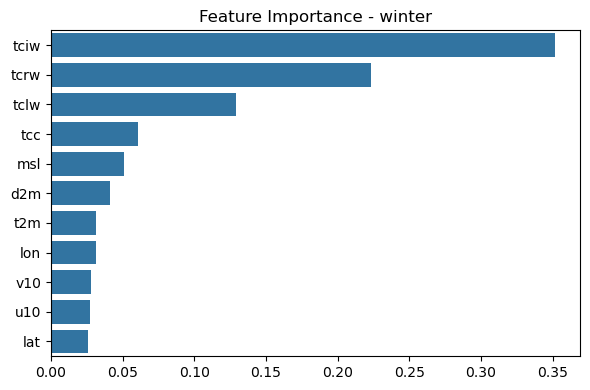


===== SPRING =====
Train samples: 370750, Test samples: 158894
Train Acc: 0.970
Test Acc:  0.944
Confusion matrix (test set):
[[107617   3819]
 [  5062  42396]]


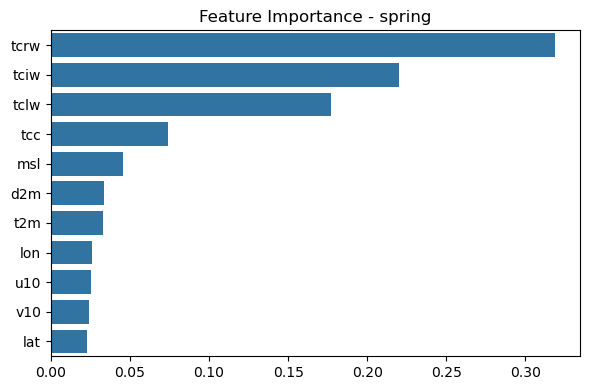


===== SUMMER =====
Train samples: 378810, Test samples: 162348
Train Acc: 0.967
Test Acc:  0.939
Confusion matrix (test set):
[[124808   3643]
 [  6290  27607]]


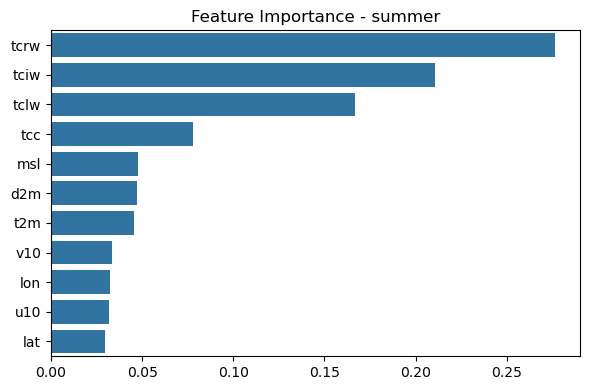


===== AUTUMN =====
Train samples: 358661, Test samples: 153712
Train Acc: 0.991
Test Acc:  0.978
Confusion matrix (test set):
[[126171   1105]
 [  2270  24166]]


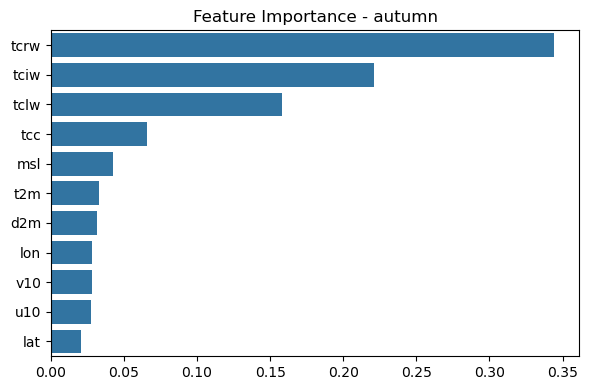


=== Summary Across Seasons ===
winter: train=0.993, test=0.980, n_train=366720, n_test=157167
spring: train=0.970, test=0.944, n_train=370750, n_test=158894
summer: train=0.967, test=0.939, n_train=378810, n_test=162348
autumn: train=0.991, test=0.978, n_train=358661, n_test=153712


In [4]:
models = {}
results = {}
test_data = {}

for season, doy_list in seasons.items():

    df_season = df_midwest[df_midwest["doy"].isin(doy_list)].dropna()

    X = df_season[feature_cols]
    y = df_season[target_col]

    # ---- Train-test split 7:3 ----
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    test_data[season] = (X_test.copy(), y_test.copy())
    
    # ---- Train Random Forest ----
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        random_state=42,
        n_jobs=-1
    )

    rf.fit(X_train, y_train)

    # ---- Predict ----
    train_pred = rf.predict(X_train)
    test_pred = rf.predict(X_test)

    # ---- Metrics ----
    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)
    cm = confusion_matrix(y_test, test_pred)
    prec = precision_score(y_test, test_pred, zero_division=0)
    rec  = recall_score(y_test, test_pred, zero_division=0)
    f1   = f1_score(y_test, test_pred, zero_division=0)

    # Save model
    models[season] = rf
    results[season] = {
        "train_acc": train_acc,
        "test_acc": test_acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "n_train": len(X_train),
        "n_test": len(X_test),
        "confusion_matrix": cm,
    }

    # Show model performance
    print(f"\n===== {season.upper()} =====")
    print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")
    print(f"Train Acc: {train_acc:.3f}")
    print(f"Test Acc:  {test_acc:.3f}")
    print("Confusion matrix (test set):")
    print(cm)

    importances = rf.feature_importances_
    sort_idx = np.argsort(importances)[::-1] 
    importances_sorted = importances[sort_idx]
    features_sorted = [feature_cols[i] for i in sort_idx]
    
    plt.figure(figsize=(6, 4))
    sns.barplot(x=importances_sorted, y=features_sorted)
    plt.title(f"Feature Importance - {season}")
    plt.tight_layout()
    plt.show()


print("\n=== Summary Across Seasons ===")
for s in results:
    print(f"{s}: train={results[s]['train_acc']:.3f}, test={results[s]['test_acc']:.3f}, "
          f"n_train={results[s]['n_train']}, n_test={results[s]['n_test']}")



The accuracy, precision, recall, and F1 for each season in test data

In [5]:
df_summary = pd.DataFrame(results).T[["test_acc", "precision", "recall", "f1"]]
df_summary

,test_acc,precision,recall,f1
winter,0.980428,0.96132,0.916111,0.938171
spring,0.944107,0.917364,0.893337,0.905191
summer,0.938817,0.883424,0.814438,0.847529
autumn,0.978043,0.956274,0.914132,0.934728


### 3. Permutation importance analysis

In [6]:
perm_results = {}

for season in seasons:
    print("Analyze the %s model" % (season))
    X_test, y_test = test_data[season]

    model = models[season]

    # ---- permutation importance ----
    result = permutation_importance(
        model, X_test, y_test,
        n_repeats=10,
        random_state=42,
        n_jobs=-1
    )

    sorted_idx = result.importances_mean.argsort()

    perm_results[season] = {
        "importances": result.importances[sorted_idx].T,
        "feature_names": np.array(feature_cols)[sorted_idx]
    }

Analyze the winter model
Analyze the spring model
Analyze the summer model
Analyze the autumn model


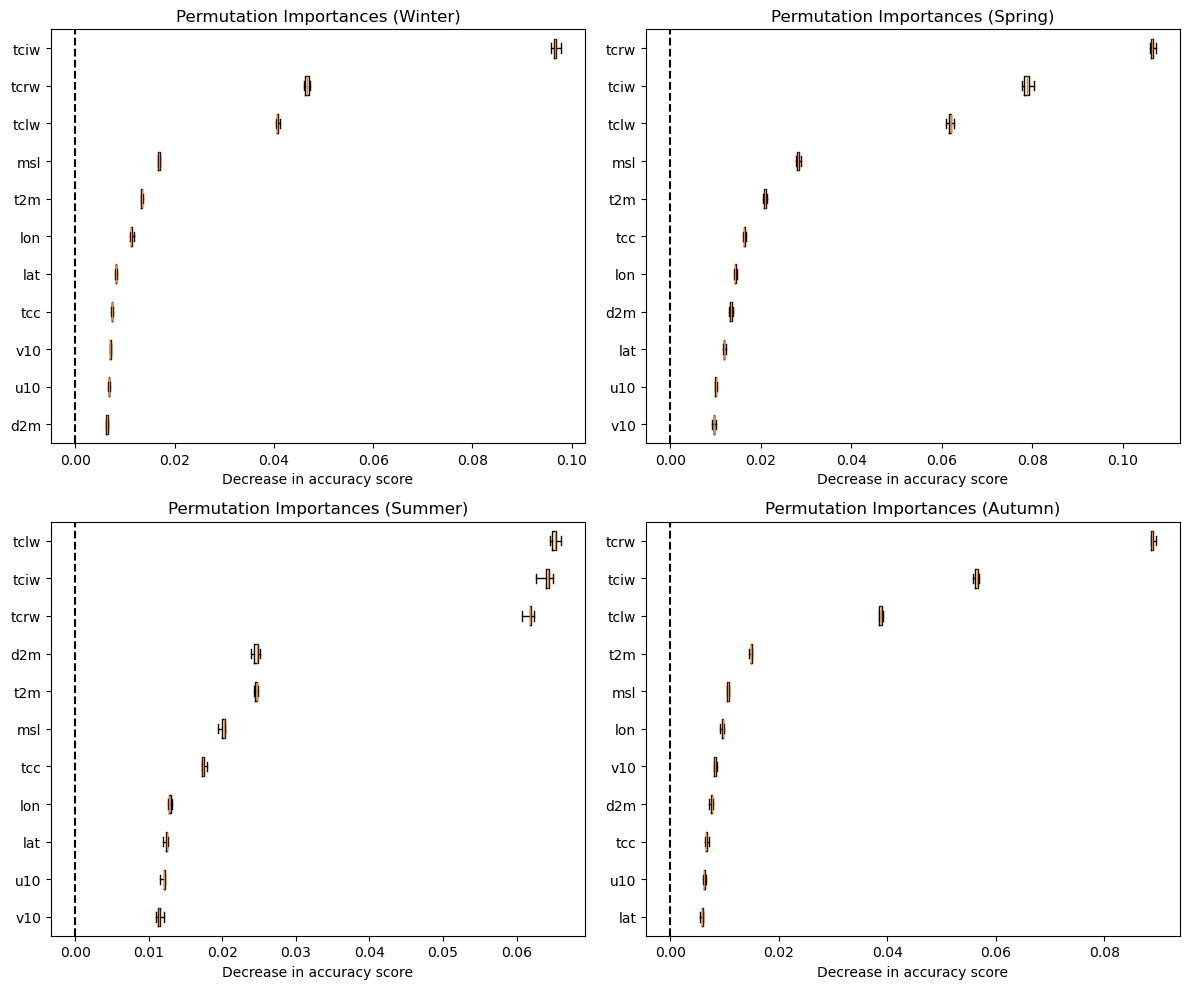

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

season_order = ["winter", "spring", "summer", "autumn"]

for ax, season in zip(axes, season_order):

    imp = perm_results[season]["importances"]
    feat_names = perm_results[season]["feature_names"]
    ax.boxplot(
        imp,
        vert=False,
        labels=feat_names,
        whis=10
    )

    ax.set_title(f"Permutation Importances ({season.capitalize()})")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.set_xlabel("Decrease in accuracy score")

plt.tight_layout()
plt.show()


### 4. SHAP analysis

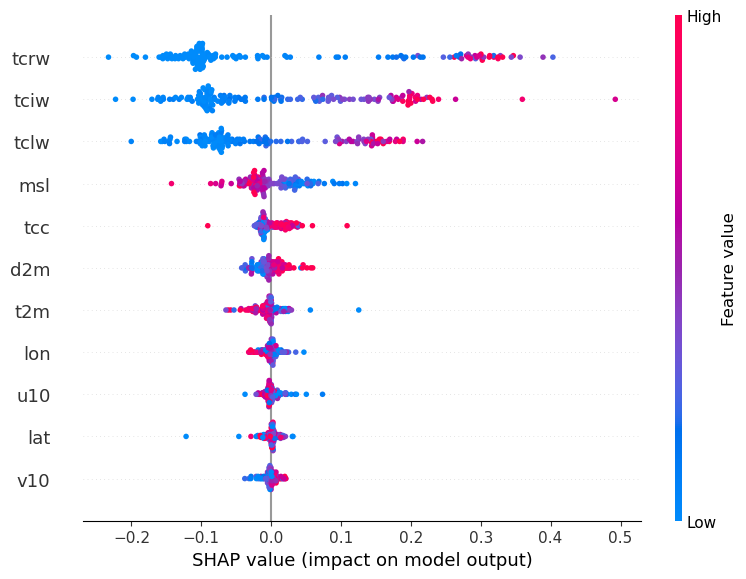

In [8]:
season = "spring"
#season = "summer"
#season = "autumn"
#season = "winter"

X_data, _ = test_data[season]
X_sample = X_data.sample(frac=0.001, random_state=42)
explainer_RF = shap.TreeExplainer(models[season])
explain_values = explainer_RF.shap_values(X_sample)[:, :, 1]
shap.summary_plot(explain_values, X_sample)

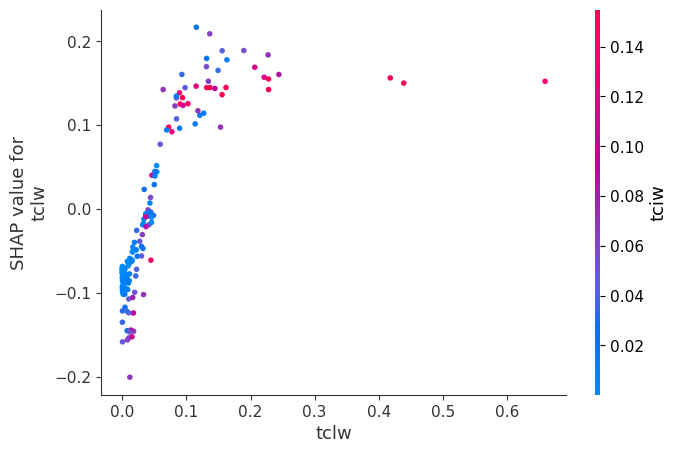

In [9]:
shap.dependence_plot("tclw", explain_values, X_sample)

### 5. Model performance maps (accuracy, precision, and recall across the entire dataset)

In [10]:
df_midwest["grid_id"] = df_midwest["lat"].astype(str) + "_" + df_midwest["lon"].astype(str)

def compute_point_metrics_fast(df_season, model):
    """
    Compute accuracy / precision / recall per grid_id
    Much faster: one-shot prediction + groupby aggregation
    """

    X = df_season[feature_cols]
    df_season = df_season.copy()
    df_season["y_pred"] = model.predict(X)

    def agg_func(g):
        y_true = g["precip_flag"]
        y_pred = g["y_pred"]

        return pd.Series({
            "lat"      : g["lat"].iloc[0],
            "lon"      : g["lon"].iloc[0],
            "accuracy" : accuracy_score(y_true, y_pred),
            "precision": precision_score(y_true, y_pred, zero_division=0),
            "recall"   : recall_score(y_true, y_pred, zero_division=0),
        })

    result = df_season.groupby("grid_id").apply(agg_func).reset_index()

    return result

season_grids = {}

for season, doy_list in seasons.items():
    
    df_season = df_midwest[df_midwest["doy"].isin(doy_list)]
    model = models[season]

    season_grids[season] = compute_point_metrics_fast(df_season, model)


In [11]:
def plot_metric(metric_name, season_grids):
    """
    metric_name: "accuracy", "precision", "recall"
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(14,10),
                             subplot_kw=dict(projection=ccrs.PlateCarree()))
    
    season_order = ["winter", "spring", "summer", "autumn"]
    axes = axes.flatten()

    for ax, season in zip(axes, season_order):

        df = season_grids[season]

        sc = ax.scatter(
            df["lon"], df["lat"],
            c=df[metric_name],
            cmap="coolwarm",
            s=20,
            vmin=0.8,
            vmax=1.0,
            transform=ccrs.PlateCarree()
        )

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.STATES, linewidth=0.3)

        ax.set_title(f"{season.capitalize()} {metric_name}")

        plt.colorbar(sc, ax=ax, shrink=0.7)

    plt.suptitle(f"{metric_name.upper()} Spatial Distribution", fontsize=16)
    plt.tight_layout()
    plt.show()



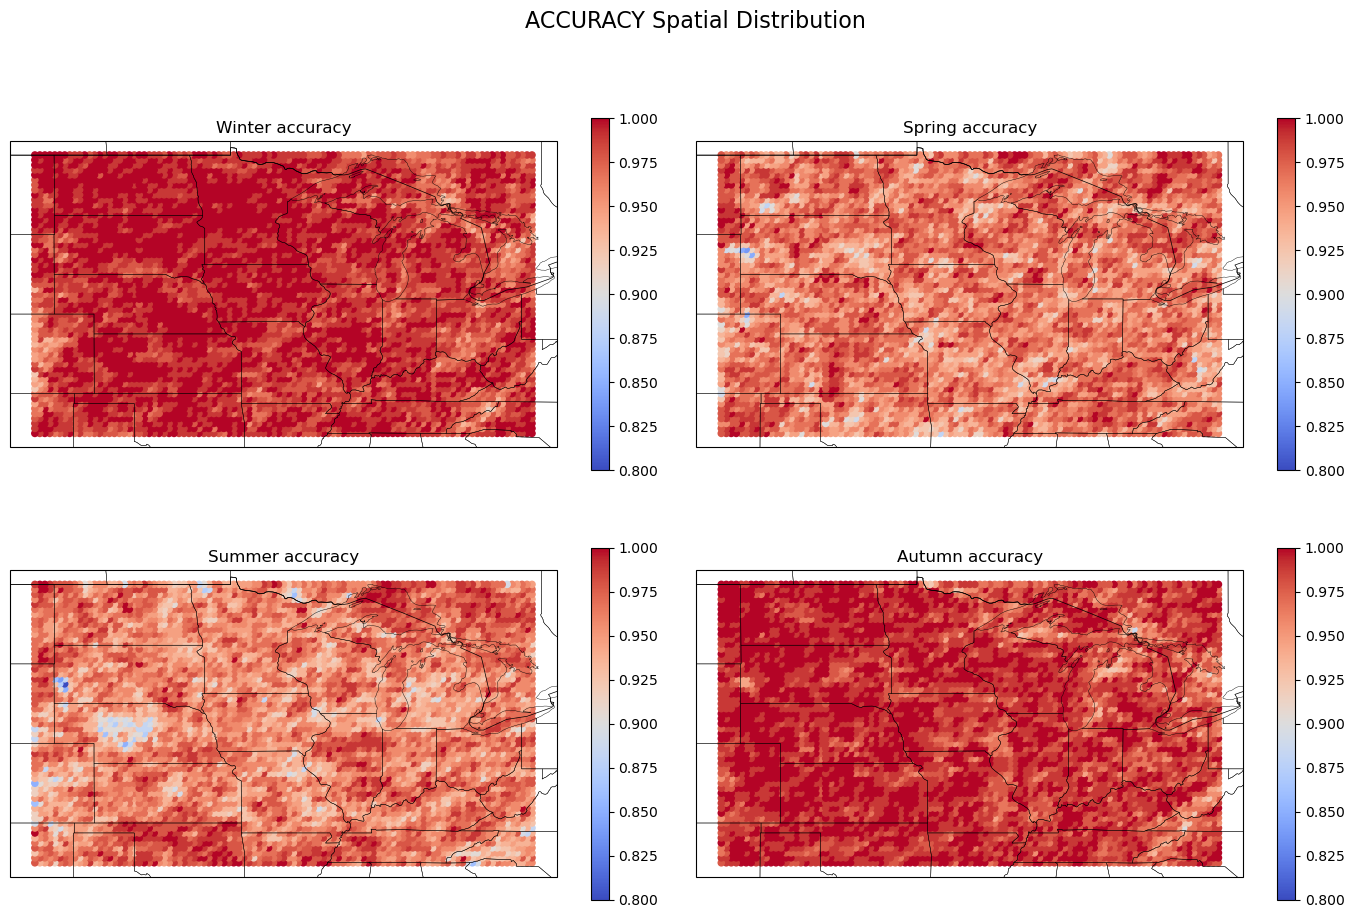

In [12]:
plot_metric("accuracy", season_grids)

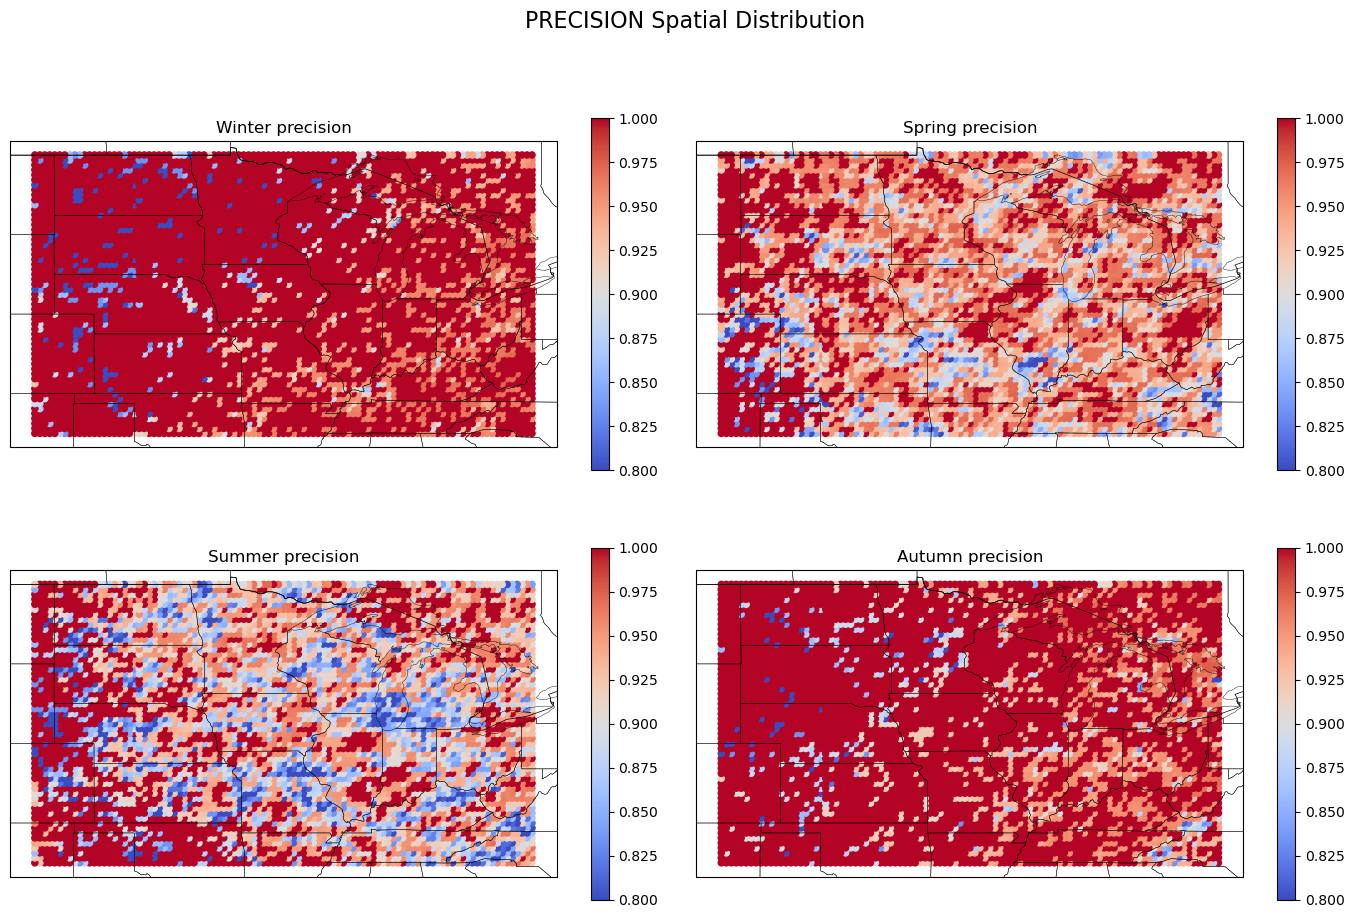

In [13]:
plot_metric("precision", season_grids)

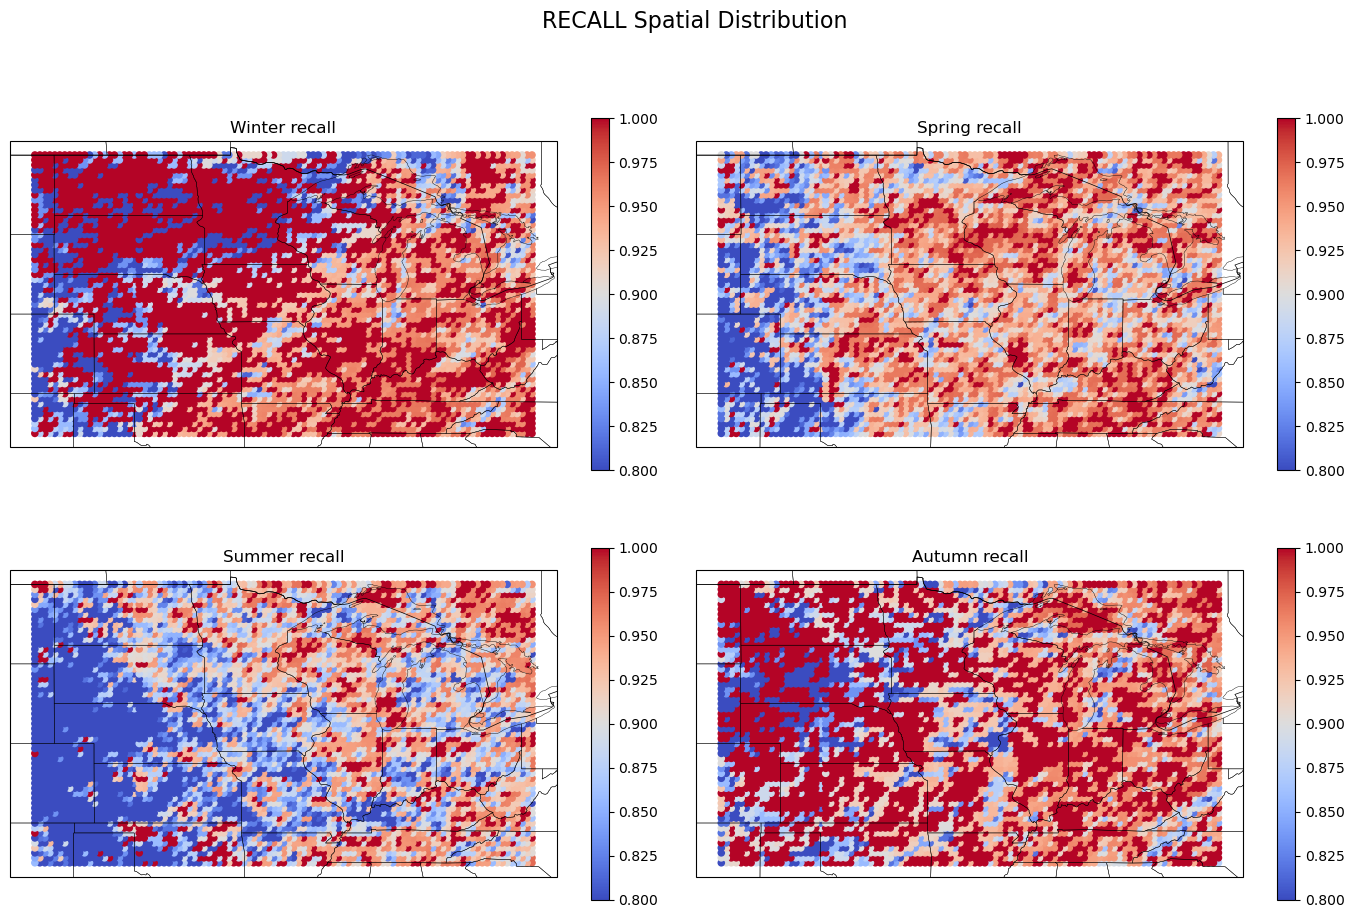

In [14]:
plot_metric("recall", season_grids)

### 6. A one-day example of precipitation prediction for the U.S. Midwest.

In [15]:
def get_season_from_doy(doy):
    if doy in seasons["winter"]:
        return "winter"
    elif doy in seasons["spring"]:
        return "spring"
    elif doy in seasons["summer"]:
        return "summer"
    else:
        return "autumn"

date_to_predict = "2024-07-14"

        
df_day = df_midwest[df_midwest["date"] == date_to_predict].copy()
doy = df_day["doy"].iloc[0]
season = get_season_from_doy(doy)

print("Prediction date:", date_to_predict)
print("DOY:", doy)
print("Season:", season)

model = models[season]

X_pred = df_day[feature_cols]
df_day["y_pred"] = model.predict(X_pred)
lats = np.sort(df_day["lat"].unique())[::-1]   # north→south
lons = np.sort(df_day["lon"].unique())
pred_grid = np.full((len(lats), len(lons)), np.nan)
true_grid = np.full((len(lats), len(lons)), np.nan)

lat_to_index = {lat: i for i, lat in enumerate(lats)}
lon_to_index = {lon: j for j, lon in enumerate(lons)}

for _, row in df_day.iterrows():
    i = lat_to_index[row["lat"]]
    j = lon_to_index[row["lon"]]
    pred_grid[i, j] = row["y_pred"]
    true_grid[i, j] = row["precip_flag"]


Prediction date: 2024-07-14
DOY: 196
Season: summer


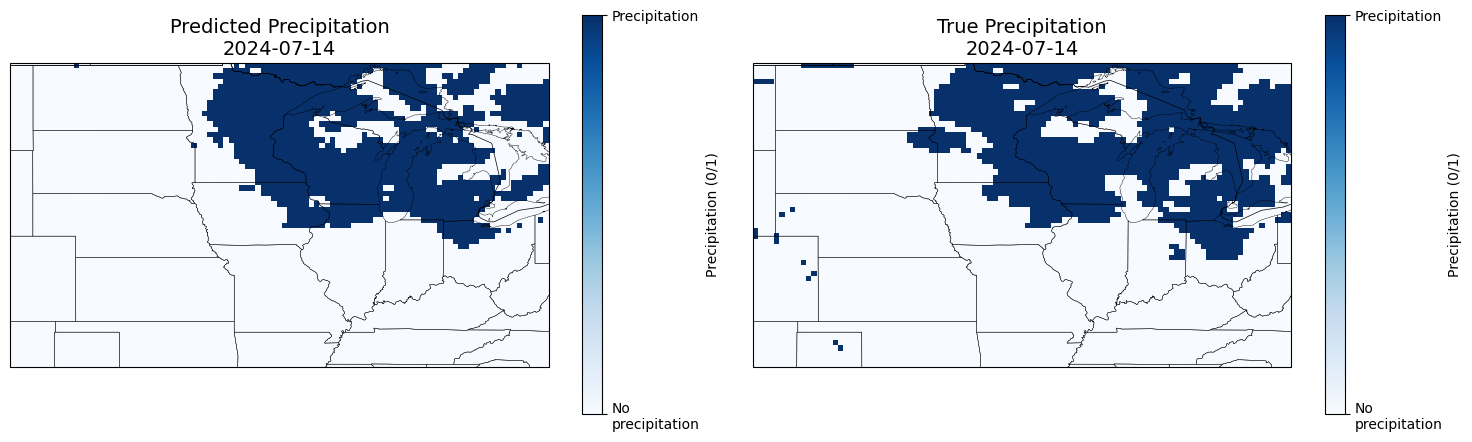

In [20]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 6), 
                         subplot_kw=dict(projection=ccrs.PlateCarree()))

titles = ["Predicted Precipitation", "True Precipitation"]
grids  = [pred_grid, true_grid]

for ax, title, grid in zip(axes, titles, grids):

    mesh = ax.pcolormesh(
        lons, lats, grid,
        cmap="Blues",
        vmin=0, vmax=1
    )

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.3)

    ax.set_title(title + f"\n{date_to_predict}", fontsize=14)

    cbar = fig.colorbar(mesh, ax=ax, shrink=0.7, label="Precipitation (0/1)")
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(["No\nprecipitation", "Precipitation"])

plt.tight_layout()
plt.show()
